In [82]:
import typing
import io
import os

import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt

from urllib.request import urlretrieve

from PIL import Image
from torchvision import transforms

from models.modeling import VisionTransformer, CONFIGS
import matplotlib.cm as cm  # For colormap
import matplotlib


In [83]:
cifar10_labels = [
    "not_present", "present"
]

def convert_to_rgb(img):
    """Check and convert the image to RGB if it's not in RGB format."""
    if img.mode != 'RGB':
        img = img.convert('RGB')
    return img


In [84]:

# Prepare Model
config = CONFIGS["ViT-B_16"]
model = VisionTransformer(config, num_classes=2, zero_head=False, img_size=224, vis=True)
model.load_state_dict(torch.load("output/copper_ring_5000_B_16_Aug200_checkpoint_Final.bin", map_location='cpu', weights_only=True), strict=False)

# model.eval()

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
])


im = Image.open("testing/copper_ring_recognition_not_present_0514.png")

im = convert_to_rgb(im)

# Check the image format
print(f"Image Format: {im.format}")

# Check the image mode (e.g., RGB, BGR, L for grayscale)
print(f"Image Mode: {im.mode}")
x = transform(im)
x.size()

Image Format: PNG
Image Mode: RGB


torch.Size([3, 224, 224])

Prediction Label and Attention Map!

0.99986 : not_present
0.00014 : present


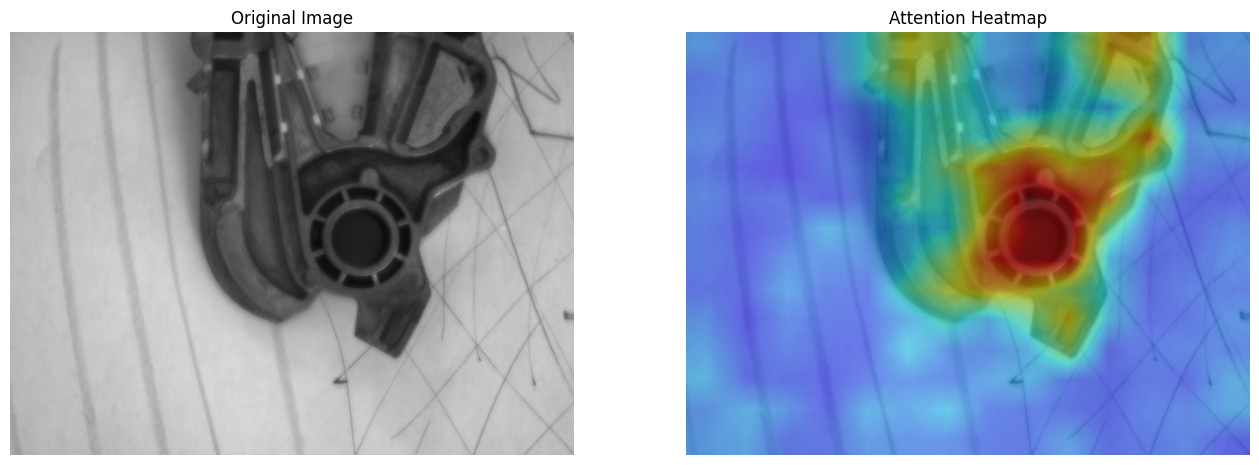

In [85]:

# Your existing code for logits and attention matrix remains the same
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1))
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size())
joint_attentions[0] = aug_att_mat[0]

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Attention from the output token to the input space
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).detach().numpy()

# Normalize the mask to be between 0 and 1
mask = mask / mask.max()

# Resize the mask to match the original image size
mask = cv2.resize(mask, im.size)[..., np.newaxis]

# Create a heatmap using a colormap
heatmap = matplotlib.colormaps['jet'](mask.squeeze())  # Change here
heatmap = (heatmap[:, :, :3] * 255).astype(np.uint8)  # Convert to uint8

# Convert the PIL image to a NumPy array
im = np.array(im)

# Overlay the heatmap on the original image
heatmap_overlay = cv2.addWeighted(heatmap, 0.5, im, 0.5, 0)

# Plot the original image and the heatmap
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))

ax1.set_title('Original Image')
ax1.imshow(im)
ax1.axis('off')  # Turn off axis

ax2.set_title('Attention Heatmap')
ax2.imshow(heatmap_overlay)
ax2.axis('off')  # Turn off axis

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)

labels = {0:"not_present",1:"present"}
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {labels[idx.item()]}', end='\n')

plt.savefig('results/Heatmap.png')
plt.show()